# Hospital placement set covering problem: Basic model

Plan:
1. Place equidistant points on a map of Vancouver to indicate possible locations for "hospitals"
2. Consider each of these points as location that must be covered as well
3. Run the set covering algorithm to see what happens

In [1]:
!! pip3 install -U numpy scipy
!! pip3 install -U googlemaps
!! pip3 install -U requests
!! pip3 install -U global-land-mask
!! pip3 install -U geopy

^C


[]

In [2]:
import googlemaps
import requests
from IPython.display import display
import math
import numpy as np
from scipy.optimize import linprog
from PIL import Image
import io
import cv2
import string
import time
from global_land_mask import globe
from geopy.distance import geodesic

api_key = open("googlemaps-apikey.txt", "r").read()
client = googlemaps.Client(key=api_key)


In [3]:
# def get_map(center, markers=[], marker_color="blue", zoom=13, fill=False):
def get_map(center, markers=[], fills=[], zoom=13):
    static_map_url = "https://maps.googleapis.com/maps/api/staticmap?"
    lat,long = center
    center = str(lat)+","+str(long)
    req = f"{static_map_url}center={center}&zoom={str(zoom)}&size=400x400&key={api_key}&sensor=false"
    
    for color, points in markers:
        req += f"&markers=color:{color}|" + "|".join([str(lat)+","+str(long) for lat,long in points])

    for points in fills:
        path = "&path=color:0x00000000|weight:5|fillcolor:0xf55742|" + "|".join([str(lat)+","+str(long) for lat,long in points])
        req = req + path

    r = requests.get(req)
    if "X-Staticmap-API-Warning" in r.headers:
        print(r.headers["X-Staticmap-API-Warning"])
        return None
    return Image.open(io.BytesIO(r.content))

In [71]:
# parsing the distance matrix
# times = client.distance_matrix(origins=center, destinations=circle)
# print("\n".join([str([elt["duration"]["text"] for elt in row["elements"]]) for row in times["rows"]]))

NINE_MINS=9*60
EIGHT_MINS_THIRTY_SEC=8.75*60
NINE_MINS_THIRTY_SEC=9.25*60

# lat,long -> encoded polyline representing the region
def distance_coverable(center):
    n = 25
    r = 0.02
    def circle_offsets():
        offsets =[]
        for i in range(n):
            deg = i/n * 2 * math.pi
            offsets.append([math.cos(deg)*r, math.sin(deg)*r])
        return offsets

    circle = [[i, center[0] + offset[0], center[1] + offset[1]] for i, offset in enumerate(circle_offsets())]
    # display_map(center, markers=circle,zoom=11, fill=True)
    unchanged = False
    # center_str = str(center[0]) + "," + str(center[1])
    max_iterations = 5
    num_iter = 0
    while num_iter < max_iterations and not unchanged:
        for point in list(circle):
            if globe.is_ocean(point[1], point[2]):
                circle.remove(point)
        num_iter += 1
        unchanged = True
        times = client.distance_matrix(origins=center, destinations=[(lat,long) for (i, lat, long) in circle])
        # print(times)
        matrix = [[elt["duration"]["value"] for elt in row["elements"]] for row in times["rows"]]
        # note: sometimes elt['status'] might be NO_RESULTS, and this line will error out
        pairs = zip(circle, matrix[0])
        circle = []
        for ((i, lat, long), time) in pairs:
            deg = i/n * 2 * math.pi
            y = (lat - center[0])
            x = (long - center[1])
            old_r = math.sqrt(x ** 2 + y ** 2)
            # print(f"deg = {deg}, old_r = {old_r}, time {time}")
            if time < EIGHT_MINS_THIRTY_SEC or time > NINE_MINS_THIRTY_SEC:
                if time == 0:
                    ratio = 10
                else:
                    ratio = NINE_MINS/time
                new_r = old_r * ratio
                # print(f"moving {ratio}, new_r = {new_r}")
                new_point = [i, center[0] +math.cos(deg)*new_r, center[1] + math.sin(deg)*new_r]
                circle.append(new_point)
                # i, lat, long = new_point
                # deg = i/n * 2 * math.pi
                # r = (lat - center[0])/math.cos(deg)
                # print(f"new deg = {deg}, r = {r}, time {time}")
                unchanged = False
            else:
                # print("done")
                circle.append([i, lat,long])
    # print(f"iterations taken = {num_iter}")
    # for point in circle:
    #     print("(test) circle distance in km", geodesic(point, center))
    return [(lat,long) for (i, lat, long) in circle]


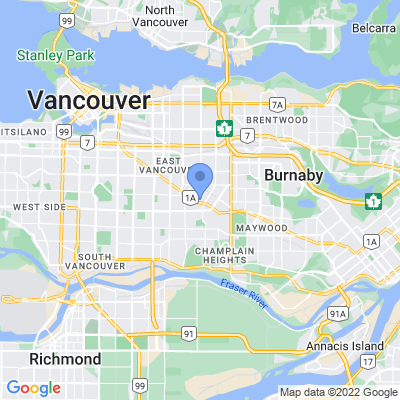

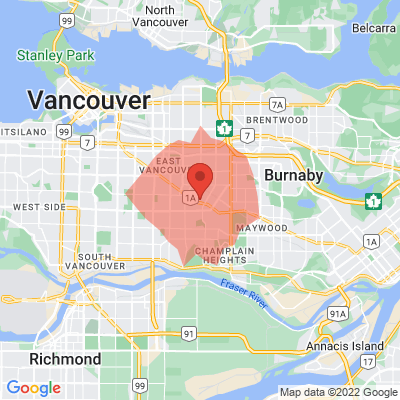

In [72]:
test_positions_burnaby = [
    (49.237564, -123.044866)
]

display(get_map(test_positions_burnaby[0], markers=[("blue",test_positions_burnaby)], zoom=11))
display(get_map(test_positions_burnaby[0], markers=[("red",test_positions_burnaby)], fills=[distance_coverable(test_positions_burnaby[0])], zoom=11))

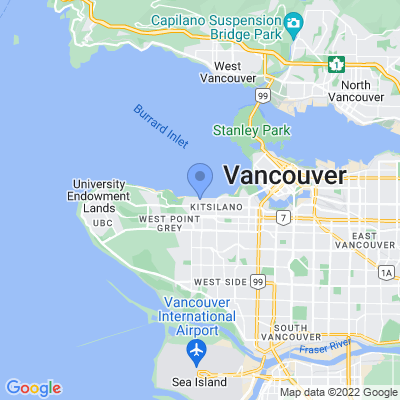

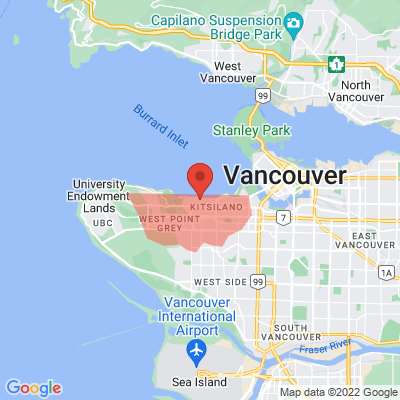

In [73]:
kits_oceanside = (49.271532, -123.179601)
display(get_map(kits_oceanside, markers=[("blue",[kits_oceanside])], zoom=11))
display(get_map(kits_oceanside, markers=[("red",[kits_oceanside])], fills=[distance_coverable(kits_oceanside)], zoom=11))

In [5]:
def is_in_city(point, city_name=None):
    res = client.reverse_geocode(point, result_type=["street_address"])
    if res == []:
        return False
    if city_name == None:
        return "formatted_address" in res[0]
    address = res[0]["formatted_address"]
    return city_name in address

In [6]:
def make_set_covering_problem(positions):
    positions = [str(lat) + "," + str(long) for lat,long in positions]
    elems_per_min = 1000
    req_per_min = elems_per_min // len(positions)
    sleep_amt = int(60/req_per_min)
    print(f"Creating set covering matrix (n = {len(positions)}) (ratelimit sleep = {sleep_amt}s)")
    covering_matrix = np.array([])
    for start in positions:
        time.sleep(sleep_amt)
        # we can only have at most 25 destination, so we have to do this
        covered = []
        for slice_start_idx in range(0, len(positions), 25):
            # print(f"slice {slice_start_idx}, {slice_start_idx + 25}")
            # TODO: the covering matrix is symmetric, we can do half the number of elements requested from the api...
            destinations_slice = positions[slice_start_idx: slice_start_idx + 25]
            matrix = client.distance_matrix(origins=start, destinations=destinations_slice)
            times = [[elt["duration"]["value"] for elt in row["elements"]] for row in matrix["rows"]][0]
            covered.extend([1 if t < NINE_MINS else 0 for t in times])
        assert(len(covered) == len(positions))
        covering_matrix = np.hstack((covering_matrix, covered))
    return covering_matrix.reshape(len(positions), len(positions))

    # the api restricts me to 100 elements per request, so this would fail on anything with more than 10 points
    # rip
    # matrix = client.distance_matrix(origins=positions, destinations=positions)
    # times = [[elt["duration"]["value"] for elt in row["elements"]] for row in matrix["rows"]]
    # covering_matrix = np.array([[1 if t < NINE_MINS else 0 for t in row] for row in times])
    # return covering_matrix.reshape(len(positions), len(positions))

In [7]:
# use the set covering problem matrix to just plug directly into linprog

def linprog_solver(points):    
    matrix = make_set_covering_problem(points)
    c = np.ones(len(points))
    b = -np.ones(len(points))
    A = -matrix
    bounds = [(0,1) for _ in points]
    solution = linprog(c, A_ub=A, b_ub=b, bounds=bounds, integrality=np.ones(len(points)))
    linprog_solution = []
    for i,chosen in enumerate(solution.x):
        if chosen == 1:
            linprog_solution.append(i)
    return linprog_solution

In [8]:
# greedy solver -> alternative to linprog to see if it makes a difference

def greedy_solve(points):
    taken = []
    matrix = make_set_covering_problem(points)
    internal = np.copy(matrix)
    print("Starting greedy solver")
    while internal.shape[0] != 0:
        # print(internal)
        values = np.sum(internal, axis=0)
        choice = np.argmax(values)
        taken.append(choice)
        # remove the rows that are now covered
        covered = internal[:,choice]
        to_delete = []
        for i,is_covered in enumerate(covered):
            if is_covered == 1:
                to_delete.append(i)
        internal = np.delete(internal, to_delete, axis=0)
        # remove the column for this choice
        # internal = np.delete(internal, (choice), axis=1)
    return sorted(taken)

In [9]:
def display_solution(center, problem, chosen_indicies, show_coverage=False):
    chosen_points = []
    for i in chosen_indicies:
        chosen_points.append(problem[i])
    
    fills = []
    if show_coverage:
        for lat,long in chosen_points:
            fills.append(distance_coverable((lat,long)))
            # break
    
    return get_map(center, markers=[("red", chosen_points), ("blue", problem)], fills=fills, zoom=11)

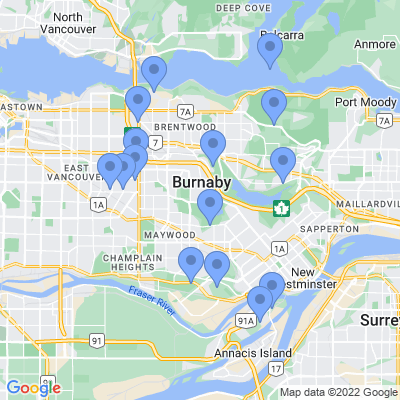

In [119]:
import random 
test_problem_burnaby_center = (49.240982, -122.981740)
n = 15
test_problem_burnaby_locations= []
for _ in range(n):
    point = [round(test_problem_burnaby_center[0] + random.uniform(-0.07, 0.07), 6), round(test_problem_burnaby_center[1] + random.uniform(-0.07, 0.07), 6)]
    while not (is_in_city(point)):
        point = [round(test_problem_burnaby_center[0] + random.uniform(-0.07, 0.07), 6), round(test_problem_burnaby_center[1] + random.uniform(-0.07, 0.07), 6)]
    test_problem_burnaby_locations.append(point)

display(get_map(test_problem_burnaby_center, markers=[("blue",test_problem_burnaby_locations)],zoom=11.5))
# print(test_problem_burnaby_locations)

Creating set covering matrix (n = 15) (ratelimit sleep = 0s)
Starting greedy solver
[3, 4, 6, 8, 13]


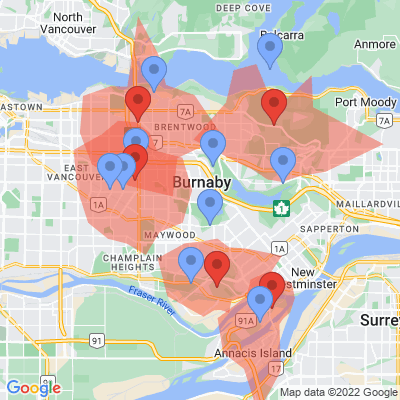

In [122]:
greedy_solution = greedy_solve(test_problem_burnaby_locations)
print(greedy_solution)
display_solution(test_problem_burnaby_center, test_problem_burnaby_locations, greedy_solution, show_coverage=True)

Creating set covering matrix (n = 15) (ratelimit sleep = 0s)
[3, 6, 9, 12, 13]


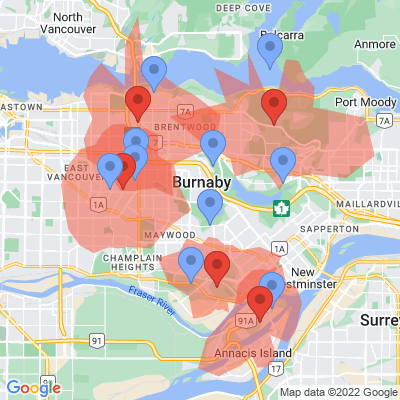

In [180]:
linprog_solution = linprog_solver(test_problem_burnaby_locations)
print(linprog_solution)
display_solution(test_problem_burnaby_center, test_problem_burnaby_locations, linprog_solution, show_coverage=True)

In [10]:
def equidistant_points(center, top_left, bottom_right, height=5, width=5, unit=0.015):    
    lat_max = top_left[0]
    long_min = top_left[1]
    lat_min = bottom_right[0]
    long_max = bottom_right[1]
    points = []
    for x in range(width//2):
        shift = False
        for y in range(height//2):
            shift = not shift
            # if shift:
            #     center = (center[0] - unit/2, center[1])
            # else:
            #     center = (center[0] + unit/2, center[1])
            points.append((center[0] - y*unit, center[1] - x*unit))
            points.append((center[0] - y*unit, center[1] + x*unit))
            points.append((center[0] + y*unit, center[1] - x*unit))
            points.append((center[0] + y*unit, center[1] + x*unit))
    # print(points[:10])
    points = list(filter(lambda p: lat_min <= p[0] <= lat_max and long_min <= p[1] <= long_max, points))
    return points

84


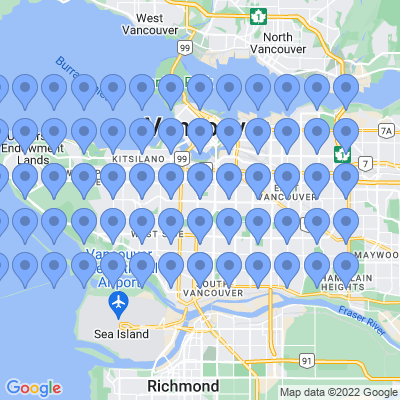

57


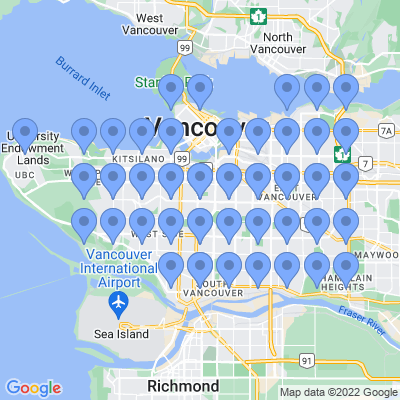

Stored 'test_problem_points' (list)


In [17]:
test_problem_center = (49.249828, -123.125774)
test_problem_top_left = (49.295863, -123.270310)
test_problem_bottom_right = (49.196127, -123.021401)
test_problem_points = equidistant_points(test_problem_center, test_problem_top_left, test_problem_bottom_right, height=6, width=20, unit=0.02)
print(len(test_problem_points))
display(get_map(test_problem_center, markers=[("blue", test_problem_points)], zoom=11))
test_problem_points = list(filter(lambda p: is_in_city(p, "Vancouver"), test_problem_points))
print(len(test_problem_points))
display(get_map(test_problem_center, markers=[("blue", test_problem_points)], zoom=11))
%store test_problem_points

Creating set covering matrix (n = 57) (ratelimit sleep = 3s)


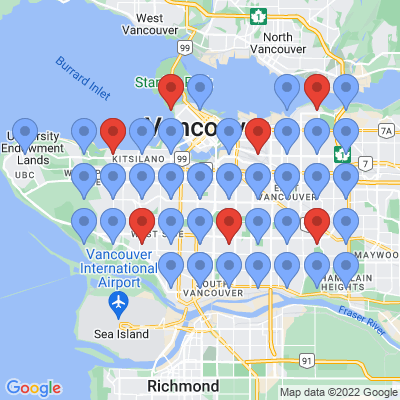

In [18]:
test_problem_solution = linprog_solver(test_problem_points)
display_solution(test_problem_center, test_problem_points, test_problem_solution, show_coverage=False)

In [20]:
%store test_problem_solution

Stored 'test_problem_solution' (list)


In [40]:
%store -r  test_problem_solution
%store -r test_problem_points

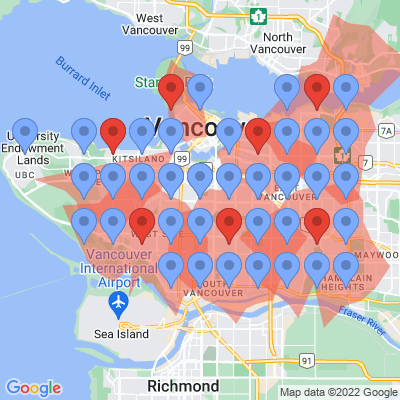

In [74]:
display_solution(test_problem_center, test_problem_points, test_problem_solution, show_coverage=True)

# Faster and rougher model

84


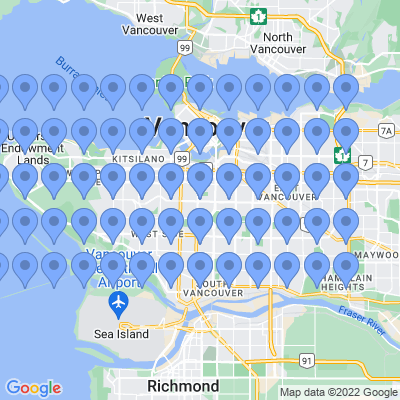

67


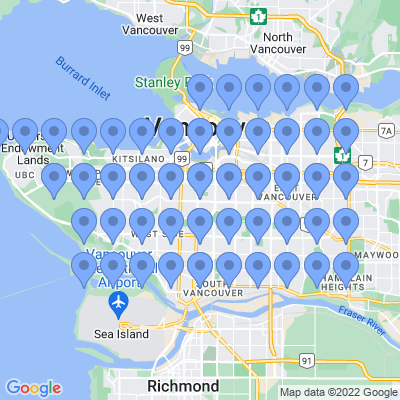

In [76]:
test_problem_center = (49.249828, -123.125774)
test_problem_top_left = (49.295863, -123.270310)
test_problem_bottom_right = (49.196127, -123.021401)
test_problem_points = equidistant_points(test_problem_center, test_problem_top_left, test_problem_bottom_right, height=6, width=20, unit=0.02)
print(len(test_problem_points))
display(get_map(test_problem_center, markers=[("blue", test_problem_points)], zoom=11))
test_problem_points = list(filter(lambda p: globe.is_land(p[0], p[1]), test_problem_points))
print(len(test_problem_points))
display(get_map(test_problem_center, markers=[("blue", test_problem_points)], zoom=11))

In [77]:
def make_set_covering_problem_straight_line(positions):
    positions = [str(lat) + "," + str(long) for lat,long in positions]
    print(f"Creating set covering matrix (n = {len(positions)}) (straight line distances)")
    covering_matrix = np.array([])
    for start in positions:
        # we can only have at most 25 destination, so we have to do this
        covered = []
        for idx, other in enumerate(positions):
            if geodesic(start, other).kilometers < 3.0:
                covered.append(1)
            else:
                covered.append(0)
        covering_matrix = np.hstack((covering_matrix, covered))
    return covering_matrix.reshape(len(positions), len(positions))

In [78]:
print(make_set_covering_problem_straight_line(test_problem_points))

Creating set covering matrix (n = 67) (straight line distances)
[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]]


In [79]:
def linprog_simple(points):    
    matrix = make_set_covering_problem_straight_line(points)
    c = np.ones(len(points))
    b = -np.ones(len(points))
    A = -matrix
    bounds = [(0,1) for _ in points]
    solution = linprog(c, A_ub=A, b_ub=b, bounds=bounds, integrality=np.ones(len(points)))
    linprog_solution = []
    for i,chosen in enumerate(solution.x):
        if chosen == 1:
            linprog_solution.append(i)
    return linprog_solution

In [80]:
simple_soln = linprog_simple(test_problem_points)

Creating set covering matrix (n = 67) (straight line distances)


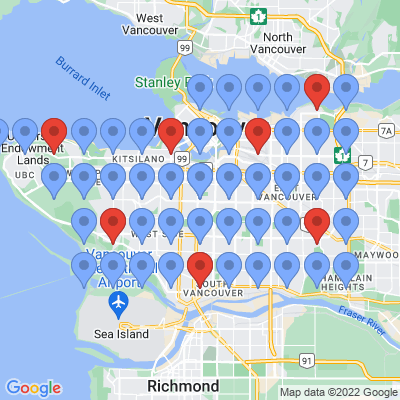

In [81]:
display_solution(test_problem_center, test_problem_points, simple_soln, show_coverage=False)

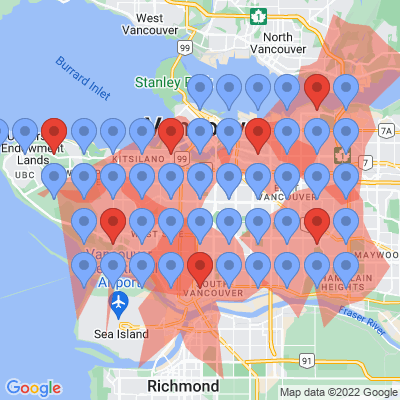

In [82]:
display_solution(test_problem_center, test_problem_points, simple_soln, show_coverage=True)